# Quickstart guide to mapping and modelling disease

This practical is written to give you a rapid overview ofhow to get started building and analysing models. The learning aim here is not to teach everything, but to present one workflow that illustrates how you can move from an experimental dataset, to gene network maps, to models. Everything in this guide is expanded on in more depth later, including the practical and theoretical aspects, but you should be able to adapt this as a starting point for your own data.

## How mutation of APC alters cancer signalling 

"Differential RNA-seq analysis comparing APC-defective and APC-restored SW480 colorectal cancer cells"
https://doi.org/10.1016/j.gdata.2016.02.001

Adenomatous polyposis coli (APC) tumour suppressor gene is mutated in 80% of colorectal cancers (CRC). Its mutation is a well studied step in the Vogelstein model of tumour development. In this dataset APC has been restored in a CRC cell line, and gene expression changes measured with RNASeq. This dataset allows us to explore the role of APC in the control of the cancer phenotype.

In this tutorial we 

* Process the raw data
* Perform differential expression analysis to identify genes activated and inhibited by the reintroduction of APC
* Use GSEA to identify pathways changed by the presence or absence of APC (to be confirmed)
* Develop maps of signalling
* Convert these maps into models

In [1]:
import pandas as pd

# Loading and processing the input data

The key steps here are 
- reading in the data from published data files
- convert raw counts to a dataframe with total counts per gene, per condition
- convert rpkm data to tpm (notes on what this means here https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/)
- perform a principal component analysis (PCA) to confirm that the samples are distinct (to ensure that the analysis will be sensible)

In [2]:
## rpkm_data
rpkm_data = pd.read_csv("./GSE76307_gene_level.rpkm.txt", sep = "\t", index_col = "Description")
## raw counts data
raw_counts = pd.read_csv("./GSE76307_transcript_counts.table.txt", sep = "\t", index_col = "Unnamed: 0")

### Curating the raw counts data

In [3]:
raw_counts.head()

,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3,sw480-1,sw480-2,sw480-3,cds_length,gene_name
NM_000014,1,1,3,1,2,2,3,2,2,4653,A2M
NM_000015,1,0,0,0,2,1,1,3,1,1317,NAT2
NM_000016,1038,1126,1098,1285,1037,1306,1022,1059,1057,2603,ACADM
NM_000017,133,111,103,171,136,174,143,147,125,1917,ACADS
NM_000018,8699,8232,8364,8888,8426,9188,10982,10844,11450,2292,ACADVL


In [4]:
## We summarise the raw counts transcipts to the gene level (just add them all up)

raw_counts = raw_counts.groupby(['gene_name']).sum()

raw_counts = raw_counts.drop("cds_length", axis =1)

In [5]:
raw_counts.head()

,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3,sw480-1,sw480-2,sw480-3
gene_name,,,,,,,,,
A1BG,3,0,2,0,0,2,0,1,3
A1BG-AS1,10,4,3,6,4,10,6,13,6
A1CF,6,0,6,0,0,6,6,18,6
A2M,1,1,3,1,2,2,3,2,2
A2M-AS1,3,6,3,4,3,3,6,11,16


### Curating the RPKM -> TPM data

In [6]:
rpkm_data.head()

,Name,sw480.1,sw480.2,sw480.3,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3
Description,,,,,,,,,,
DDX11L1,NR_046018,0.029243,0.000000,0.028825,0.000000,0.000000,0.000000,0.028771,0.032629,0.000000
WASH7P,NR_024540,10.022390,9.784377,10.255849,8.056397,7.294954,7.735621,7.657351,9.202215,8.199277
LOC729737,NR_039983,0.308885,0.281063,0.260970,0.572778,0.510475,0.507493,0.269165,0.167401,0.259120
LOC100132062,NR_028325,0.077384,0.022004,0.032690,0.043484,0.034878,0.011772,0.032629,0.037004,0.020941
LOC100288069,NR_033908,4.686485,5.611010,4.758363,3.776909,3.001679,3.752356,3.882773,3.853025,3.037023


In [7]:
## remove the name column
rpkm_data = rpkm_data.drop("Name", axis =1)

##### Convert rpkm to TPM

In [8]:
rpkm_data.head()

,sw480.1,sw480.2,sw480.3,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3
Description,,,,,,,,,
DDX11L1,0.029243,0.000000,0.028825,0.000000,0.000000,0.000000,0.028771,0.032629,0.000000
WASH7P,10.022390,9.784377,10.255849,8.056397,7.294954,7.735621,7.657351,9.202215,8.199277
LOC729737,0.308885,0.281063,0.260970,0.572778,0.510475,0.507493,0.269165,0.167401,0.259120
LOC100132062,0.077384,0.022004,0.032690,0.043484,0.034878,0.011772,0.032629,0.037004,0.020941
LOC100288069,4.686485,5.611010,4.758363,3.776909,3.001679,3.752356,3.882773,3.853025,3.037023


In [9]:
## TPM = (rpkm/total reads in sample) * 1 million
TPM_data = pd.DataFrame()

for col in rpkm_data.columns:
    totalreads = rpkm_data[col].sum()
    
    TPM_data[col] = rpkm_data[col].apply(lambda row: (row/totalreads) * 10**6)

In [10]:
TPM_data.head()

,sw480.1,sw480.2,sw480.3,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3
Description,,,,,,,,,
DDX11L1,0.073737,0.000000,0.071810,0.000000,0.000000,0.000000,0.070465,0.079016,0.000000
WASH7P,25.271794,24.974742,25.549966,19.396767,17.000899,18.372652,18.754201,22.284504,19.992728
LOC729737,0.778863,0.717417,0.650144,1.379034,1.189663,1.205333,0.659232,0.405385,0.631826
LOC100132062,0.195126,0.056166,0.081439,0.104692,0.081284,0.027960,0.079914,0.089611,0.051061
LOC100288069,11.817130,14.322172,11.854310,9.093372,6.995417,8.912112,9.509596,9.330662,7.405333


In [11]:
## We now have:
##  - raw counts data (use for input to DESeq and other tools requiring the raw counts)
##  - TPM data (use for visualisation, GSEA, and other similar tools required normalised data)

## Perform PCA to check samples are distinct

In [12]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaled_TPM = StandardScaler().fit_transform(TPM_data.T)

In [13]:
## Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_TPM)

In [14]:
## Make a dataframe and calculate the percentage contribution of each PC
principal_Df = pd.DataFrame(data = principal_components
             , columns = ['PC1', 'PC2'])

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.46778784 0.21758848]


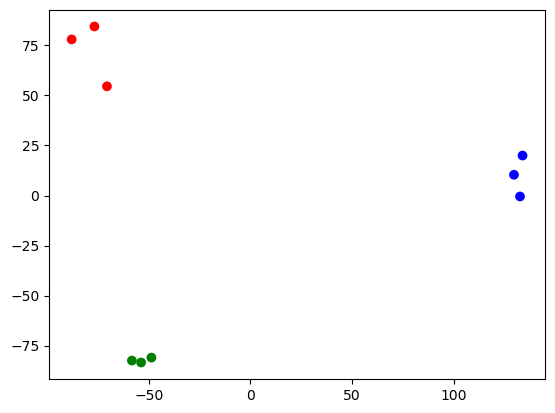

In [15]:
## Plot the PCs

## This can all be made to look a lot nicer and a bit more robust
import matplotlib.pyplot as plt

plt.scatter(x = principal_Df["PC1"], y = principal_Df["PC2"], c = ["r", "r", "r", "b", "b", "b", "g", "g", "g"])

plt.show()

# Differential expression using DESeq2 

Generally this would be done in R, but as a python implementation is available I am using it. Here we identify genes showing substantial and significant changes (achieved by examining log fold changes, LFC, and p values) across the datasets. In this particular set we have three conditions; WT, mutant, and control. Control shouldn't be different from WT, so can be used to exclude a subset of false positives.

### Set up our data

In [16]:
## raw counts is fed into deseq2 transposed compared to our usual format
counts_df = raw_counts.T

## We remove genes with very low counts (<10 counts across our samples)
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [17]:
counts_df.head()

gene_name,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
sw480_APC_1,3,10,6,1,3,56,0,1769,1004,1,...,1181,3173,5611,231,576,1185,504,5068,1362,721
sw480_APC_2,0,4,0,1,6,49,0,1613,858,0,...,1152,3173,5673,232,567,1056,470,4459,1247,700
sw480_APC_3,2,3,6,3,3,37,0,1661,852,2,...,1140,3035,5720,187,591,1082,449,4781,1190,663
sw480_CONTROL_1,0,6,0,1,4,101,1,3163,732,4,...,1208,2945,6892,84,252,1637,708,7802,1342,870
sw480_CONTROL_2,0,4,0,2,3,84,1,2814,627,3,...,1090,2600,6026,78,241,1431,576,7876,1111,698


In [18]:
## We make our metadata matrix - in this case we just have one condition with 3 levels
conditions = ["APC_mut"] * 3 + ["Control"] * 3 + ["WT"] * 3

metadata = pd.DataFrame(conditions, index= raw_counts.columns, columns=["condition"])

In [19]:
metadata.head()

,condition
sw480_APC_1,APC_mut
sw480_APC_2,APC_mut
sw480_APC_3,APC_mut
sw480_CONTROL_1,Control
sw480_CONTROL_2,Control


## Run deseq2 with Control as the "base factor" (will do a comparison of the other two factors against the control)

In [20]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [21]:
## We make the deseqdataset (the data structure deseq uses)
inference = DefaultInference(n_cpus=8)
dds_control = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    ref_level = ["condition", "Control"])

/home/benjamin/anaconda3/lib/python3.11/site-packages/pydeseq2/dds.py:250: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [22]:
## Run deseq2 (differential expression analysis)
dds_control.deseq2()

Fitting size factors...
... done in 0.21 seconds.

Fitting dispersions...
... done in 8.60 seconds.

Fitting dispersion trend curve...
... done in 1.16 seconds.

Fitting MAP dispersions...
... done in 8.15 seconds.

Fitting LFCs...
... done in 4.39 seconds.

Refitting 0 outliers.



In [23]:
## Look at the log fold change values
dds_control.varm["LFC"].head()

,intercept,condition_WT_vs_Control,condition_APC-mut_vs_Control
gene_name,,,
A1BG,-0.441712,0.691604,0.974337
A1BG-AS1,1.882836,0.199119,-0.125480
A1CF,0.654150,1.609863,0.758713
A2M,0.513939,0.295413,0.033406
A2M-AS1,1.201971,1.157952,0.217498


### Calcluate p values and shrink LFCs for APC mut vs Control

In [24]:
## APC mut vs Control

## Set up the pvalue calculation
stat_res_APCvsControl = DeseqStats(dds_control, inference=inference, contrast = ["condition", "APC-mut", "Control"], quiet = True)

## Calculate p values
stat_res_APCvsControl.summary(quiet = True)

## We shrink our fold changes
stat_res_APCvsControl.lfc_shrink(coeff="condition_APC-mut_vs_Control")

Log2 fold change & Wald test p-value: condition APC-mut vs Control
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_name                                                                  
A1BG          1.201651        1.405671  1.971693  0.712926  4.758916e-01   
A1BG-AS1      6.768256       -0.181029  0.752814 -0.240470  8.099658e-01   
A1CF          5.196975        1.094592  1.217199  0.899271  3.685084e-01   
A2M           1.888791        0.048195  1.301985  0.037017  9.704716e-01   
A2M-AS1       6.021168        0.313784  0.847597  0.370204  7.112306e-01   
...                ...             ...       ...       ...           ...   
ZXDC       1443.856959       -0.470899  0.055675 -8.457938  2.721474e-17   
ZYG11B      600.154339       -0.442237  0.082114 -5.385676  7.217294e-08   
ZYX        7164.599004       -0.699490  0.071278 -9.813605  9.838925e-23   
ZZEF1      1355.558492        0.019842  0.065011  0.305218  7.602001e-01   
ZZZ3        771.52102

In [25]:
## Save our output
stat_res_APCvsControl.results_df.to_csv("APC_APCmut_vs_Control_LFC.csv")

In [26]:
stat_res_APCvsControl.results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_name,,,,,,
A1BG,1.201651,0.180877,0.721680,0.712926,0.475892,0.572397
A1BG-AS1,6.768256,-0.088979,0.530282,-0.240470,0.809966,0.860557
A1CF,5.196975,0.317698,0.695540,0.899271,0.368508,0.465555
A2M,1.888791,0.011911,0.644403,0.037017,0.970472,0.980471
A2M-AS1,6.021168,0.137274,0.565664,0.370204,0.711231,0.783162


### Calcluate p values and shrink LFCs for WT vs Control

In [27]:
## WT vs Control

## Set up the pvalue calculation
stat_res_WTvsControl = DeseqStats(dds_control, inference=inference, contrast = ["condition", "WT", "Control"], quiet = True)

## Calculate p values
stat_res_WTvsControl.summary(quiet = True)

## We shrink our fold changes
stat_res_WTvsControl.lfc_shrink(coeff="condition_WT_vs_Control")

Log2 fold change & Wald test p-value: condition WT vs Control
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene_name                                                                     
A1BG          1.201651        0.997774  1.996850  0.499674  0.617305       NaN
A1BG-AS1      6.768256        0.287267  0.725602  0.395902  0.692177  0.795980
A1CF          5.196975        2.322542  1.173313  1.979473  0.047763  0.102712
A2M           1.888791        0.426190  1.256309  0.339240  0.734429       NaN
A2M-AS1       6.021168        1.670571  0.779962  2.141862  0.032205  0.073796
...                ...             ...       ...       ...       ...       ...
ZXDC       1443.856959        0.021101  0.053746  0.392598  0.694617  0.797742
ZYG11B      600.154339       -0.038229  0.079441 -0.481224  0.630357  0.749374
ZYX        7164.599004        0.104478  0.070800  1.475673  0.140032  0.245832
ZZEF1      1355.558492        0.195392  0.064272  3.040077  0.002365 

In [28]:
## Save our output
stat_res_WTvsControl.results_df.to_csv("APC_WT_vs_Control_LFC.csv")

In [29]:
### To get the final comparison (APC vs WT) we need to rerun deseq2 with WT as the "base factor"

In [30]:
## We make the deseqdataset (the data structure deseq uses)
inference = DefaultInference(n_cpus=8)
dds_WT = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    ref_level = ["condition", "WT"])

/home/benjamin/anaconda3/lib/python3.11/site-packages/pydeseq2/dds.py:250: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [31]:
## Run deseq2 (differential expression analysis)
dds_WT.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 8.81 seconds.

Fitting dispersion trend curve...
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 7.27 seconds.

Fitting LFCs...
... done in 4.41 seconds.

Refitting 0 outliers.



### Calculate p values and shrink LFC for APC vs WT

In [32]:
## APC vs WT

## Set up the pvalue calculation
stat_res_APCvsWT = DeseqStats(dds_WT, inference=inference, contrast = ["condition", "APC-mut", "WT"], quiet = True)

## Calculate p values
stat_res_APCvsWT.summary(quiet = True)

## We shrink our fold changes
stat_res_APCvsWT.lfc_shrink(coeff="condition_APC-mut_vs_WT")

Log2 fold change & Wald test p-value: condition APC-mut vs WT
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
gene_name                                                                   
A1BG          1.201651        0.407894  1.825031   0.223500  8.231464e-01   
A1BG-AS1      6.768256       -0.468301  0.738071  -0.634493  5.257591e-01   
A1CF          5.196975       -1.227948  1.090972  -1.125554  2.603542e-01   
A2M           1.888791       -0.377989  1.256532  -0.300819  7.635525e-01   
A2M-AS1       6.021168       -1.356785  0.757268  -1.791684  7.318367e-02   
...                ...             ...       ...        ...           ...   
ZXDC       1443.856959       -0.492000  0.055491  -8.866260  7.564388e-19   
ZYG11B      600.154339       -0.404008  0.082065  -4.923026  8.521602e-07   
ZYX        7164.599004       -0.803968  0.071191 -11.293139  1.418779e-29   
ZZEF1      1355.558492       -0.175549  0.064355  -2.727828  6.375287e-03   
ZZZ3        77

In [33]:
## Save our output
stat_res_APCvsWT.results_df.to_csv("APC_APCmut_vs_WT_LFC.csv")

## Gene set overlaps

We have now performed differential expression - to get genes of interest we need to calculate overlaps. The genes changed by APC manipulation should be those that overlap between the two APC mut comparisons, but excluding those different between WT and control

We can illustrate the overlaps by making a Venn diagram

In [34]:
## APCmut vs WT
APCmut_vs_WT = stat_res_APCvsWT.results_df[stat_res_APCvsWT.results_df["padj"] <= 0.05]

APCmut_vs_WT = APCmut_vs_WT[abs(APCmut_vs_WT["log2FoldChange"]) > 2]

APCmut_vs_WT_genes = set(APCmut_vs_WT.index.tolist())

In [35]:
## APCmut vs Control
APCmut_vs_Control = stat_res_APCvsControl.results_df[stat_res_APCvsControl.results_df["padj"] <= 0.05]

APCmut_vs_Control = APCmut_vs_Control[abs(APCmut_vs_Control["log2FoldChange"]) > 2]

APCmut_vs_Control_genes = set(APCmut_vs_Control.index.tolist())

In [36]:
## WT vs Control
WT_vs_Control = stat_res_WTvsControl.results_df[stat_res_WTvsControl.results_df["padj"] <= 0.05]

WT_vs_Control = WT_vs_Control[abs(WT_vs_Control["log2FoldChange"]) > 2]

WT_vs_Control_genes = set(WT_vs_Control.index.tolist())

## Make a venn diagram

In [37]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

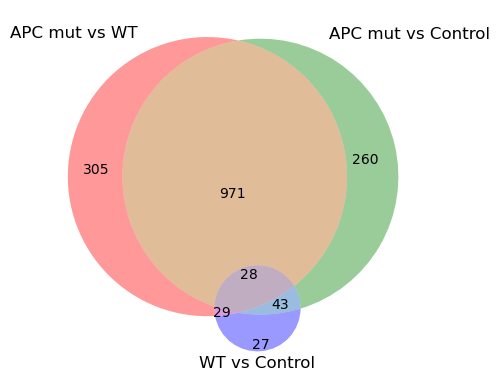

In [38]:
venn3([APCmut_vs_WT_genes, APCmut_vs_Control_genes, WT_vs_Control_genes]
     ,set_labels = ("APC mut vs WT", "APC mut vs Control", "WT vs Control"))
plt.show()

971 genes are overlapping in the mutant conditions and not involved in the vector. Reassuringly, we also find relatively few in the WT vs control set.

In [39]:
APCmut_genes = list((APCmut_vs_Control_genes & APCmut_vs_WT_genes) - WT_vs_Control_genes)

## Visualise data for confirmation

Here we seek to confirm that the genes identified are correct by returning to the TPM data, and plotting a heatmap of the expression of the genes identified as differentially expressed. This seems obvious, but in addition to offering a visualisation of the effect it confirms that our analysis has been sound. To draw out the clusters of genes associated with each condition, we further cluster the heatmap.

In [40]:
heatmap_genes = TPM_data.T[APCmut_genes].T

heatmap_genes = heatmap_genes.loc[~(heatmap_genes==0).all(axis=1)]


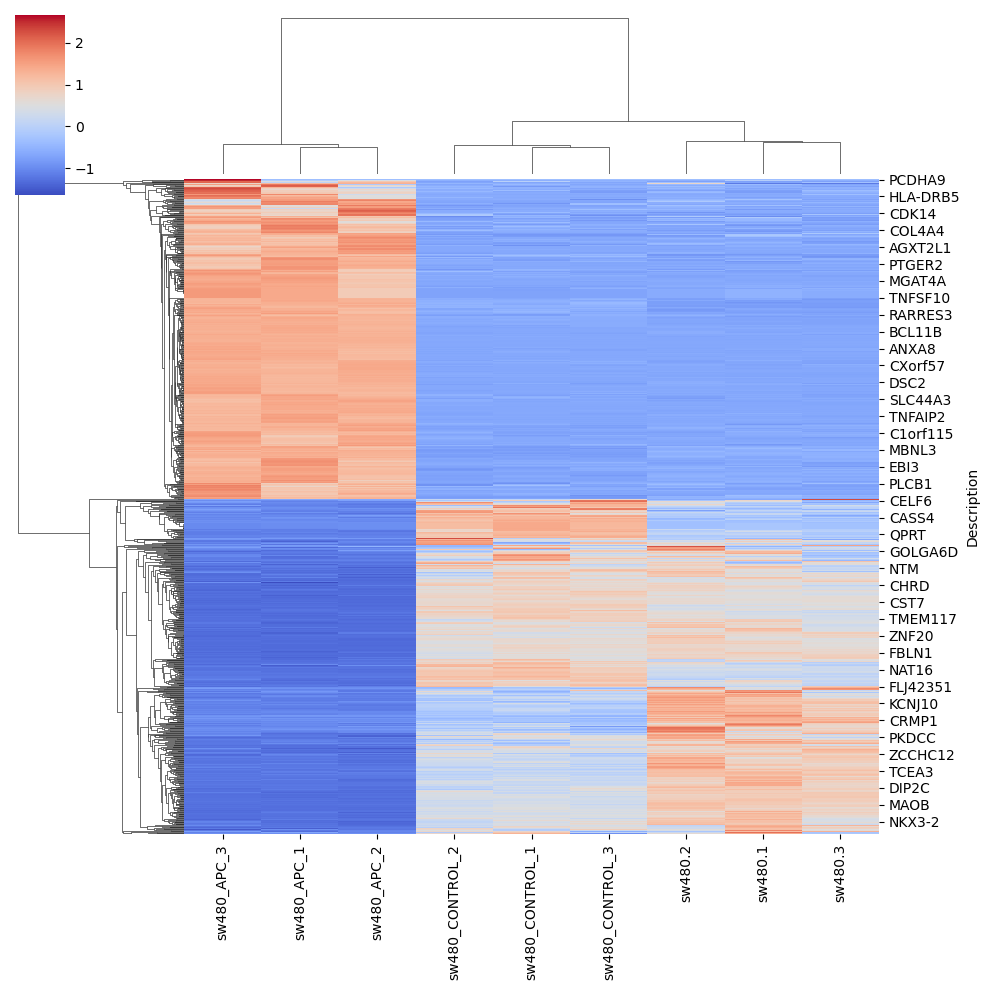

In [41]:
import seaborn as sns
sns.clustermap(heatmap_genes, z_score= 0, metric= "euclidean", cmap = "coolwarm")
plt.show()

## Pathway analysis

here we use two common tools; GSEA an GProfiler to identify functions that the genes are involved in. These may confirm elements of the biology we are looking to test, and could assist us in our later modelling; alternatively, if we are exploring the dataset, it draws out key features and phenotypes to be aware of.

from gprofiler import GProfiler

gp = gprofiler(return_dataframe=True)
#gp = gprofiler()
gp.profile(organism='hsapiens',
            query=APCmut_genes)

In [42]:
import gseapy as gp

enr = gp.enrichr(gene_list=APCmut_genes, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )



In [43]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    enr.results.sort_values(by=['Adjusted P-value'])
    display(enr.results[enr.results["Adjusted P-value"] < 0.05])

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Inflammatory Response,45/200,2.854500e-18,1.313070e-16,0,0,5.917439,239.050535,RTP4;CXCL6;CSF3;CSF1;PTGER2;ITGB3;EBI3;PTAFR;L...
1,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,39/200,7.703329e-14,1.771766e-12,0,0,4.903980,148.073413,CXCL6;CSF2;SDC4;CSF1;PLEK;TNFAIP2;TNFAIP3;CXCL...
2,MSigDB_Hallmark_2020,KRAS Signaling Up,37/200,1.795914e-12,2.753734e-11,0,0,4.585082,124.005859,SNAP25;SPON1;CSF2;SATB1;CXCR4;TNFAIP3;PTGS2;HD...
3,MSigDB_Hallmark_2020,Interferon Gamma Response,34/200,1.571238e-10,1.806924e-09,0,0,4.123272,93.078693,RTP4;CD274;SAMD9L;CIITA;TNFAIP2;TNFAIP3;PTGS2;...
4,MSigDB_Hallmark_2020,Allograft Rejection,31/200,9.992728e-09,9.193309e-08,0,0,3.680347,67.797183,CSF1;GCNT1;FASLG;HDAC9;CTSS;ICAM1;CCND2;NLRP3;...
5,MSigDB_Hallmark_2020,Complement,27/200,1.487081e-06,1.140095e-05,0,0,3.117419,41.831702,ITGAM;LRP1;PLEK;TNFAIP3;CXCL1;CLU;CTSS;PIK3R5;...
6,MSigDB_Hallmark_2020,IL-6/JAK/STAT3 Signaling,16/87,3.882501e-06,2.551358e-05,0,0,4.473534,55.735904,CNTFR;CSF2;CSF1;ITGB3;EBI3;CXCL1;CXCL3;PIK3R5;...
7,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,26/200,4.691694e-06,2.697724e-05,0,0,2.981390,36.580814,CXCL6;ECM1;SDC4;LRP1;WIPF1;NTM;ITGB3;COL12A1;T...
8,MSigDB_Hallmark_2020,Interferon Alpha Response,16/97,1.649554e-05,8.431052e-05,0,0,3.919178,43.159635,RTP4;CD74;SAMD9L;CSF1;SAMD9;SP110;IL15;DDX60;I...
9,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,24/199,3.779811e-05,1.738713e-04,0,0,2.730403,27.804378,CDKN1C;IL10;ECM1;CSF2;CSF1;PTGER2;TNFRSF9;PTH1...


In [44]:
## Gene list which can be copy-pasted into many online tools as well
for item in APCmut_genes:
    print(item)

CGNL1
KLF12
NKX3-2
ZNF704
GSTM1
ST14
LEF1-AS1
MAOB
PTGER2
INHBB
HMGCS2
LINC00479
VIL1
LOC100131138
ALK
SLC16A14
PPM1H
GRID1
TRIM34
CD4
NPAS2
GPR173
GJB1
RGS7
ARHGEF16
REEP2
HIST1H2BK
SEPT5-GP1BB
AR
TERC
PAX2
PARM1
MEI1
PPARG
ANXA8L1
EYA1
ACOX2
PCDHA10
CENPVP1
DLL1
LAMC2
SP140L
CACNA1S
PNMA6C
DCDC2
CD70
DEFB1
HS3ST1
LOC100506178
ICAM4
LRRN1
HBA2
TMEM45A
NFAM1
CTSO
ITGBL1
AGXT2L1
VSX1
CDH3
ANXA8
ACVR1C
HLA-DQB1
PADI2
KIF21B
RLBP1
LGR5
CASP1
SLC44A3
SDR16C5
CNTNAP2
TNFAIP3
SMAD6
GBP1
NOS2
NR3C2
GOLGA6D
FGF18
EFNB1
PMEPA1
TTBK1
CAPN6
NIPAL1
PCDHA2
MARVELD3
HSPB8
PRPH
LRCOL1
PLAU
CCDC3
SAA2-SAA4
ETV7
MAP7
STXBP6
SRRM3
DMRT3
SH3BGRL
PLCE1
CYGB
RYR1
TMEM144
CAPN8
SPOCK2
UBASH3A
TBC1D30
NKD1
SLC1A2
FGD4
SNCG
KANK1
PRR9
MMP28
ASB2
ABCC6P1
CCDC37
PRSS22
KCTD12
PKDCC
ENAH
SLPI
GRM8
PRLR
GSX1
HIST1H2AD
KCNS3
AREG
NLRP3
C8orf47
SKAP1
LEF1
SSPN
LOC255167
TMC4
CXCL5
EFNA5
WT1-AS
RUNDC3A
UGT1A3
ITIH3
TPSG1
DOCK8
SLC7A8
PODNL1
NRXN2
SPINT1
BMPR1B
LAD1
FXYD3
TFAP2E
HIST1H2AC
PLCB1
GSTM2
PDE4D
KYNU
CXCL1

# Getting started with mapping networks

We've got a long list of genes now to start building a network. This is useful, but too long to practically turn into a network immediately;there is no practical way to turn >10s of genes into a network. Fundamentally, we need to prioritise which genes we study first. This can be done based on biological knowledge, effectively using a subset of well studied genes as a prior- in this instance we could pick one GSEA term for example as our starting point, using our function of interest to guide us.

What we will do for the purpose of this tutorial initially is to prioritise based on increasing the significance and fold change thresholds. To simplify this process we rewrite some of the code above into subrouteines

In [45]:
def topDiff(a,thresholdP, thresholdF):
    ## APCmut vs WT
    out = a.results_df[a.results_df["padj"] <= thresholdP]

    out = out[abs(out["log2FoldChange"]) > thresholdF]

    result = set(out.index.tolist())
    
    return(result)

def threshold(P,F):
    APCmut_vs_WT_genes = topDiff(stat_res_APCvsWT, P, F)
    APCmut_vs_Control_genes = topDiff(stat_res_APCvsControl, P, F)
    WT_vs_Control_genes =  topDiff(stat_res_WTvsControl, P, F)
    APCmut_genes = list((APCmut_vs_Control_genes & APCmut_vs_WT_genes) - WT_vs_Control_genes)
    return(APCmut_genes)

In [46]:
print(len(threshold(0.05,2))) # original thresholds
print(len(threshold(0.003,4))) # three sigma, 2^4 fold difference
print(len(threshold(0.00007,8))) # four sigma, 2^8 fold difference

971
238
11


The selected thresholds are arbitrary, but can be useful to thin the large list.

In [51]:
smallset = threshold(0.00007,8)
for item in smallset: 
    print(item)

CXCL6
C3
BMPR1B
PLEKHS1
PTPRZ1
ALPL
GALNT3
HLA-DRB1
CXCL14
CCL2
MIR205HG


## Checking for internal consistency

Our smallset should resemble the larger set; a straightforward way to check this is to repeat GSEA on the new set. Examining the top terms we find a reasonable match- but of course this should be guided by your interest in the biology.

In [48]:
enr = gp.enrichr(gene_list=smallset, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [49]:
enr.results.sort_values(by=['Adjusted P-value'])
enr.results[enr.results["Adjusted P-value"]<0.05]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,2/200,0.005157,0.027504,0,0,22.212121,117.000045,CXCL6;CCL2
1,MSigDB_Hallmark_2020,Interferon Gamma Response,2/200,0.005157,0.027504,0,0,22.212121,117.000045,CCL2;HLA-DRB1
2,MSigDB_Hallmark_2020,Inflammatory Response,2/200,0.005157,0.027504,0,0,22.212121,117.000045,CXCL6;CCL2
16,KEGG_2021_Human,Cytokine-cytokine receptor interaction,4/295,0.000014,0.000356,0,0,38.680412,432.021505,CXCL6;CCL2;BMPR1B;CXCL14
17,KEGG_2021_Human,Rheumatoid arthritis,3/93,0.000016,0.000356,0,0,82.912500,917.527195,CXCL6;CCL2;HLA-DRB1
18,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,3/100,0.000019,0.000356,0,0,76.902062,834.256871,CXCL6;CCL2;CXCL14
19,KEGG_2021_Human,Chemokine signaling pathway,3/192,0.000136,0.001867,0,0,39.285714,349.817130,CXCL6;CCL2;CXCL14
20,KEGG_2021_Human,Pertussis,2/76,0.000767,0.007212,0,0,59.804805,429.015805,C3;CXCL6
21,KEGG_2021_Human,Leishmaniasis,2/77,0.000787,0.007212,0,0,59.004444,421.739196,C3;HLA-DRB1
22,KEGG_2021_Human,IL-17 signaling pathway,2/94,0.001169,0.008210,0,0,48.060386,324.471367,CXCL6;CCL2


## Exploring the literature for connectivity

Here we explore different databases of gene interactions to assist developing a network model. APC need to be added to our list of genes of interest as changes in expression should be expected to flow from APC mutation.

### HuRI

HuRI (http://www.interactome-atlas.org/search) is a powerful resource summarising both the literature and a high-throughput interaction screen. We can use this to propose connectivity. Our list however includes several genes not found in its database

- PTPRZ1
- GALNT3
- CXCL6
- MIR205HG

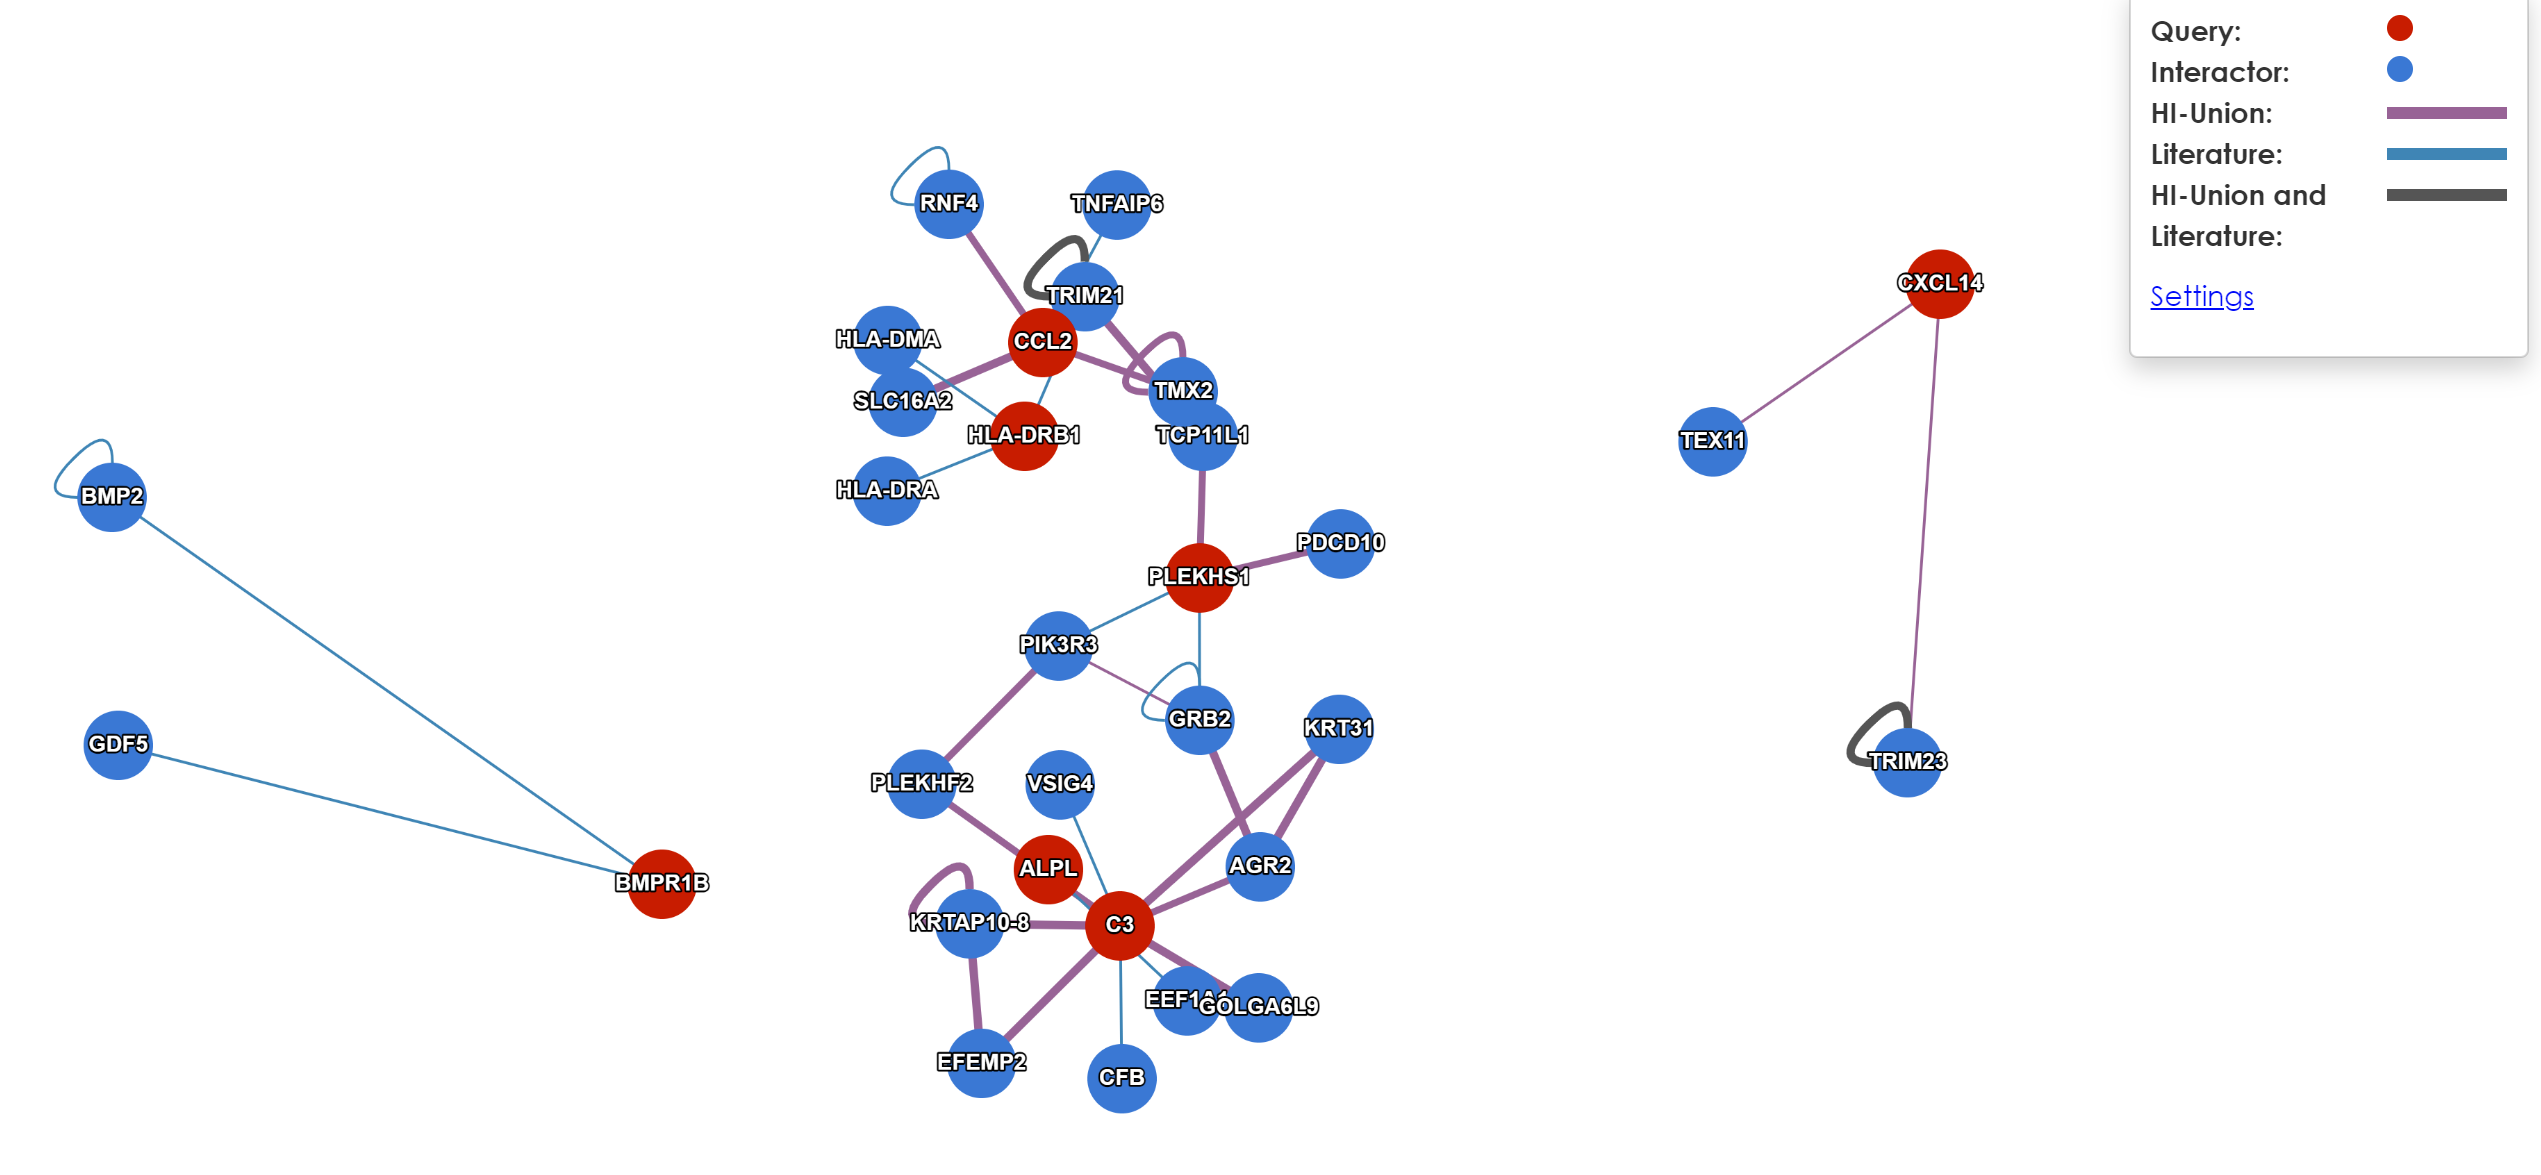

How plausible are the new interaction partners? A simple way to address that is to reexamine the original list and ask which of these new genes are members

In [50]:
huri = ["BMP2","GDF5","RNF4","TNFAIP6","TRIM21","HLA-DMA","SLC16A2","HLA-DRA","TMX2",
        "TCP11L1","PDCD10","PIJ3R3","GRB2","AGR2","KRT31","VSIG4","PLEKHF2","KRTAP10-8",
       "EFEMP2", "CFB", "TEX11", "TRIM23", "GOLGA6L9", "EFF1A1"]

print(set(APCmut_genes) & set(huri))

{'HLA-DRA', 'BMP2'}


Only HLA-DRA and BMP2 are found in both lists. For this task, HuRI has not been suitable, but for other gene lists it may be better.

### ACSN
(can we do this from here?)


### GeneMania

Whilst the microRNA MIR205G is unrecognised, all other genes are found and co-expression and co-localisation generate a network of genes. Different plots show the complexity of the network, but gene interactions, taken from Lin et al 2010 (https://pubmed.ncbi.nlm.nih.gov/20508145/) offer a useful starting place, connecting most genes in the set to APC.

#### All

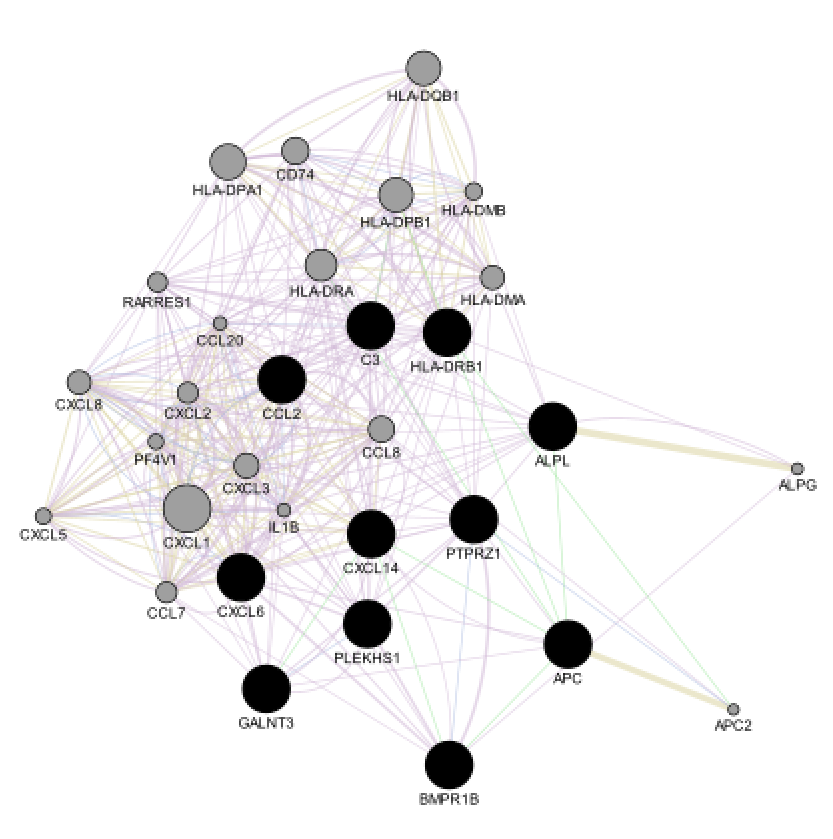

#### Co-localisation (blue) and gene interactions (green)

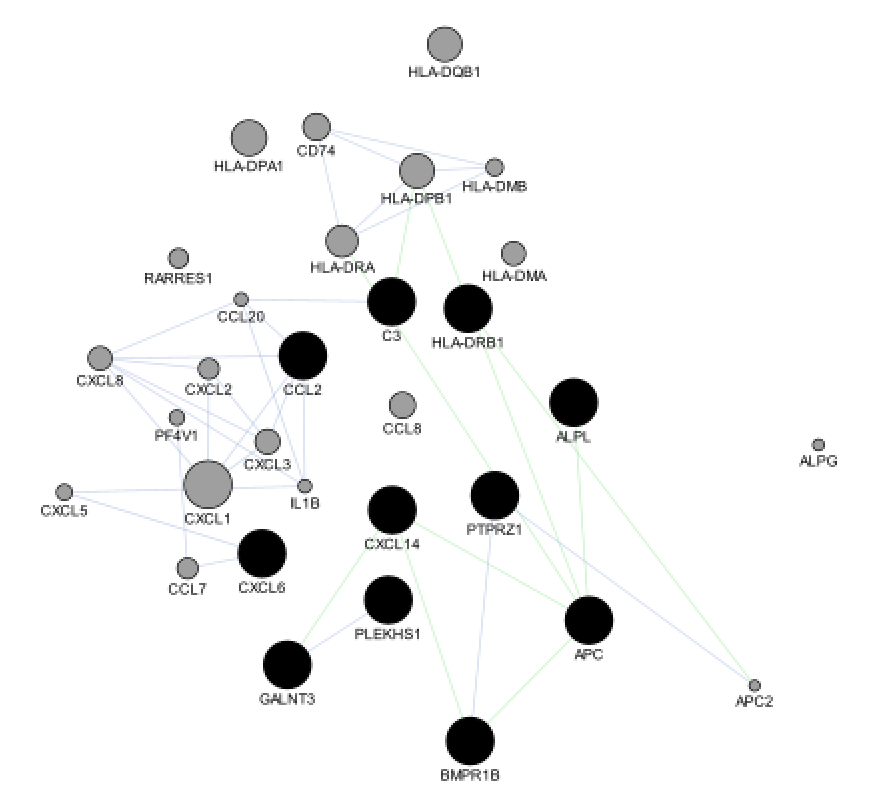

#### Co-expression alone

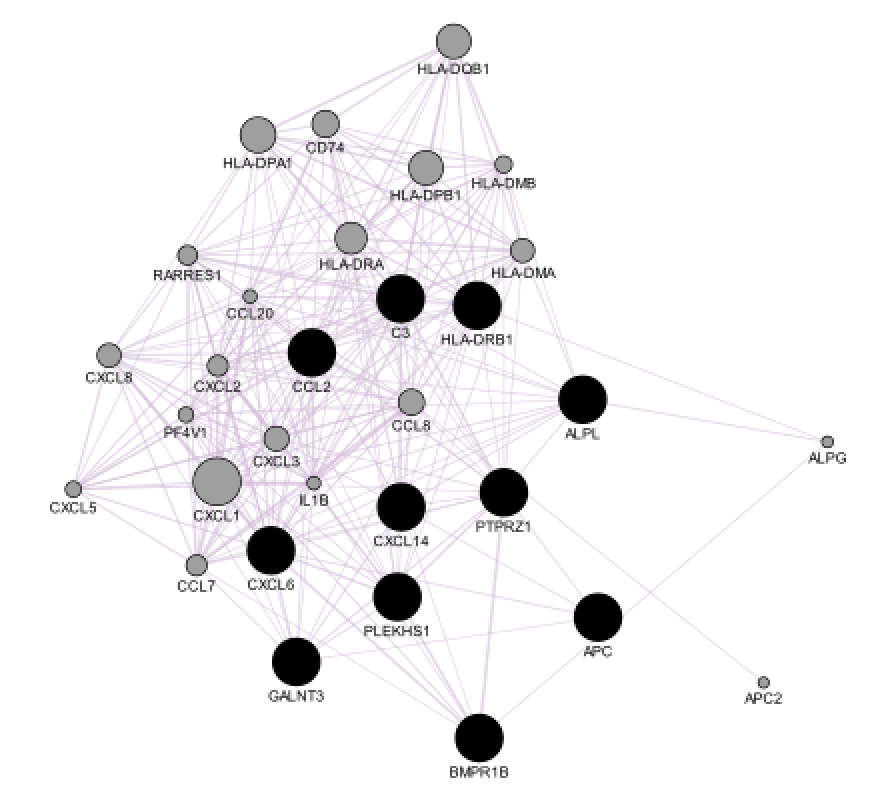

In [57]:
genemaniaTXT = """ALPG
ALPL
BMPR1B
C3
CCL2
CCL20
CCL7
CCL8
CD74
CXCL1
CXCL14
CXCL2
CXCL3
CXCL5
CXCL6
CXCL8
GALNT3
HLA-DMA
HLA-DMB
HLA-DPA1
HLA-DPB1
HLA-DQB1
HLA-DRA
HLA-DRB1
IL1B
LTF
PF4V1
PLEKHS1
PTPRZ1
RARRES1"""

genemania = set(genemaniaTXT.split("\n")) - set(smallset)
print(list( genemania & set(APCmut_genes)))

['CXCL5', 'CXCL3', 'HLA-DQB1', 'HLA-DPB1', 'CXCL1', 'CD74', 'CCL20', 'CXCL2', 'HLA-DRA', 'IL1B']
